# Recommender systems

## Metacritic dataset

### Caricamento librerie

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score

import networkx as nx

from re import sub

ModuleNotFoundError: No module named 'nltk'

In [2]:
stop = stopwords.words("english")
stop.append("expand")

NameError: name 'stopwords' is not defined

### Caricamento dataset

In [3]:
df = pd.read_json("data/metacritic_data.json")

In [4]:
df.sample(10)

,name,platform,developer,publisher,genre(s),players,rating,attribute,summary,release_date,link,critic_positive,critic_neutral,critic_negative,metascore,user_positive,user_neutral,user_negative,user_score
17083,Action News Heroes,XONE,Krewe Studios,Krewe Studios,Action,None,T,None,Obliterate your enemies with violent soul crus...,"Jul 27, 2016",/game/xbox-one/action-news-heroes,0,2,2,49,4,0,0,8.1
7492,MLB Power Pros 2008,PS2,Konami,2K Sports,Sports,1-2,E,None,With over ten different exciting game modes in...,"Jul 29, 2008",/game/playstation-2/mlb-power-pros-2008,2,6,1,67,6,0,1,8.5
8115,Guitar Hero: Metallica,PS3,Neversoft Entertainment,Activision,Action,None,T,None,Guitar Hero: Metallica takes music fans throug...,"Mar 29, 2009",/game/playstation-3/guitar-hero-metallica,41,3,0,86,4,0,0,8.1
10982,Dungeons,PC,Realmforge Studios,Kalypso,Strategy,None,M,None,Dungeons follows the mis-adventures of the for...,"Feb 10, 2011",/game/pc/dungeons,13,19,3,65,10,14,22,4.6
5093,FlatOut 2,PC,Bugbear,Vivendi Games,Driving,No Online Multiplayer,T,None,Featuring an enhanced version of the original'...,"Aug 1, 2006",/game/pc/flatout-2,17,7,0,76,46,4,3,8.7
12505,Assassin's Creed IV: Black Flag,PC,Ubisoft,Ubisoft,Action Adventure,None,M,None,The year is 1715. Pirates rule the waters of t...,"Nov 19, 2013",/game/pc/assassins-creed-iv-black-flag,8,2,0,84,204,59,60,7.8
15580,Mushroom Men: Truffle Trouble,PC,Red Fly Studio,Red Fly Studio,Action,No Online Multiplayer,None,None,In this follow up title to Mushroom Men: The S...,"Mar 10, 2015",/game/pc/mushroom-men-truffle-trouble,0,5,1,55,1,0,0,tbd
20401,Past Cure,PS4,Phantom 8,Phantom 8,Action,No Online Multiplayer,M,None,Past Cure is a dark psychological thriller tha...,"Feb 23, 2018",/game/playstation-4/past-cure,0,7,15,37,7,3,6,4.9
14598,Jamestown+,PS4,"Final Form Games, LLC","Final Form Games, LLC",Scrolling,None,E10+,None,Jamestown: Legend Of The Lost Colony is a neo-...,"Mar 17, 2015",/game/playstation-4/jamestown+,5,1,0,83,3,1,0,7.3
8459,Ghostbusters: The Video Game,PC,Terminal Reality,Atari,Action,None,T,None,The Ghostbusters are back in an all new story ...,"Jun 16, 2009",/game/pc/ghostbusters-the-video-game,16,10,0,74,28,13,3,7.7


### Selezione giochi appartenenti all'attuale generazione di console

In [5]:
consoles = ["PS4", "XONE", "Switch"]
df = df[df["platform"].isin(consoles)]

### Creazione nuove features

In [6]:
df["# critic"] = df["critic_positive"] + df["critic_neutral"] + df["critic_negative"]
df["# users"] = df["user_positive"] + df["user_neutral"] + df["user_negative"]

### Selezione feature da processare

In [7]:
df = df[["name", "platform", "developer", "publisher", "genre(s)", "players", "rating", "summary"]]

In [8]:
df.head()

,name,platform,developer,publisher,genre(s),players,rating,summary
12412,flower,PS4,Bluepoint Games,SCEA,General,1 Player,E,The pioneers that brought you the PLAYSTATION ...
12426,FIFA 14,XONE,EA Canada,EA Sports,Sim,Up to 22,E,Shooting has been transformed. Players now hav...
12447,FIFA 14,PS4,EA Canada,EA Sports,Sports,Up to 22,E,"Fuelled by EA SPORTS IGNITE, FIFA 14 feels ali..."
12459,NBA 2K14,XONE,Visual Concepts,2K Sports,Sim,Up to 10,E,"NBA 2K14 promises to raise the bar yet again, ..."
12481,Battlefield 4,PS4,EA DICE,Electronic Arts,Action,Up to 64,M,Battlefield 4 is an action blockbuster that ai...


### Preparazione colonna platform

In [9]:
df["platform"].unique()

array(['PS4', 'XONE', 'Switch'], dtype=object)

In [10]:
map_platform = {"PS4": 2, "XONE": 1, "Switch": 0}
df["platform"] = df["platform"].map(map_platform)

### Preparazione colonna players

In [11]:
df["players"].value_counts()

No Online Multiplayer    1419
Up to 4                   200
2                         169
Up to 8                   110
Up to 6                    67
Online Multiplayer         61
Up to 12                   47
Up to 10                   42
Up to 16                   38
Up to 22                   17
Up to 64                   13
Massively Multiplayer      12
Up to 5                    12
Up to 18                   11
Up to 3                    11
Up to 24                   10
Up to 32                    9
Up to 40                    9
Up to 20                    7
Up to more than 64          5
Up to 30                    3
1 Player                    3
                            3
Up to 9                     2
1-2                         1
Name: players, dtype: int64

In [12]:
df["players"] = df["players"].apply(lambda x: 0 if x == "No Online Multiplayer" else 1)

### Preparazione colonna rating

In [13]:
df["rating"].unique()

array(['E', 'M', 'E10+', 'T', None], dtype=object)

In [14]:
map_rating = {"E": 0, "E10+": 1, "T": 2, "M": 3, None: -1}
df["rating"] = df["rating"].map(map_rating)

### Creazione colonna testi

In [15]:
df["text"] = df["developer"] + " " + df["publisher"]+ " " + df["genre(s)"] + " " + df["summary"]

### Preparazione colonna text

In [16]:
def clean_text(row):
    try:
        text = sub(r"[^\w\s]", " ", row)
        return " ".join([word.lower() for word in word_tokenize(text)
                         if word not in stop])
    except Exception:
        return row

In [17]:
df["text"] = df["text"].apply(clean_text)

### Selezione feature da inserire nel modello

In [18]:
df = df[["name", "platform", "players", "rating", "text"]]
df.dropna(subset=["text"], inplace=True)
df.reset_index(drop=True, inplace=True)

In [19]:
df.head()

,name,platform,players,rating,text
0,flower,2,1,0,bluepoint games scea general the pioneers brou...
1,FIFA 14,1,1,0,ea canada ea sports sim shooting transformed p...
2,FIFA 14,2,1,0,ea canada ea sports sports fuelled ea sports i...
3,NBA 2K14,1,1,0,visual concepts 2k sports sim nba 2k14 promise...
4,Battlefield 4,2,1,3,ea dice electronic arts action battlefield 4 a...


### Vettorizzazione testi

In [20]:
tfidf = TfidfVectorizer(strip_accents="unicode", ngram_range=(1, 2), max_features=12500)

In [21]:
text = tfidf.fit_transform(df["text"])

### Creazione matrice features

In [22]:
X = np.c_[df["platform"].values, df["players"].values, df["rating"].values, text.todense()]

### Clustering

### Riduzione dimensionalità matrice

In [23]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

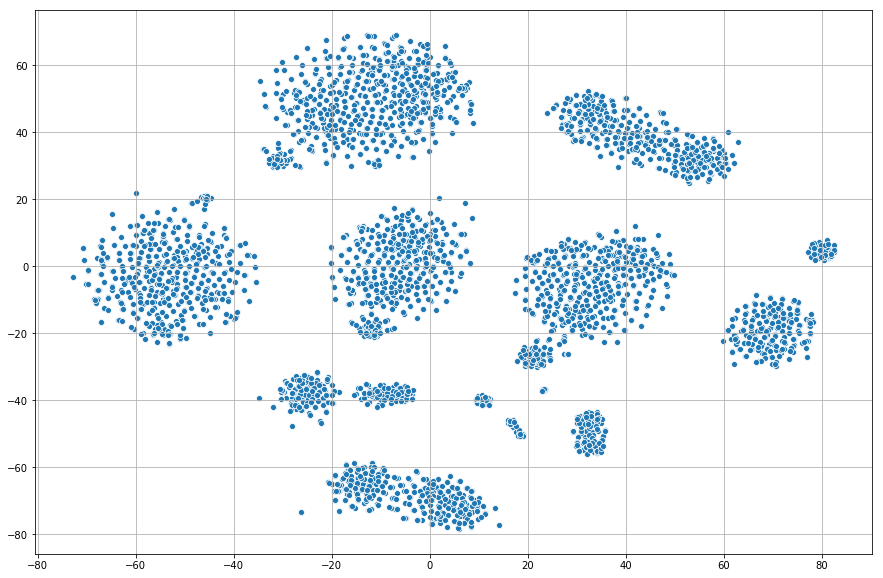

In [24]:
plt.figure(figsize=(15, 10))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1])
plt.grid()
plt.show()

### K-Means

In [25]:
scores = []
for k in range(2, 20):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_tsne)
    scores.append({"k": k, "sse": km.inertia_, "score": silhouette_score(X_tsne, km.labels_)})

In [26]:
data = pd.DataFrame(scores)
data

,k,score,sse
0,2,0.361776,6.129593e+06
1,3,0.428187,3.600796e+06
2,4,0.461231,2.347065e+06
3,5,0.476901,1.768130e+06
4,6,0.539672,1.199260e+06
5,7,0.575234,9.022612e+05
6,8,0.585621,7.141575e+05
7,9,0.603348,5.669352e+05
8,10,0.560118,4.966536e+05
9,11,0.519998,4.550315e+05


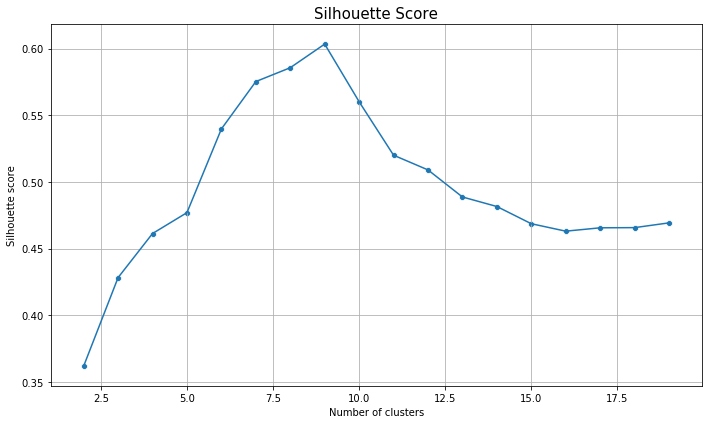

In [27]:
plt.figure(figsize=(10, 6))
sns.lineplot(x="k", y="score", data=data)
sns.scatterplot(x="k", y="score", data=data)
plt.title("Silhouette Score", fontsize=15)
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score")
plt.grid()
plt.tight_layout()
plt.show()

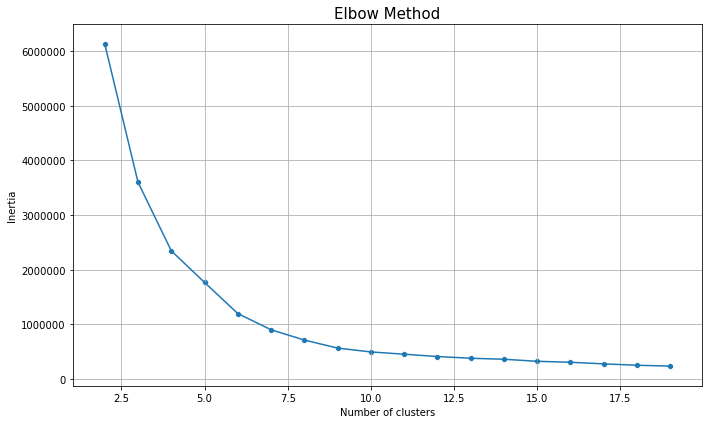

In [28]:
plt.figure(figsize=(10, 6))
sns.lineplot(x="k", y="sse", data=data)
sns.scatterplot(x="k", y="sse", data=data)
plt.title("Elbow Method", fontsize=15)
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.grid()
plt.tight_layout()
plt.show()

In [29]:
km = KMeans(n_clusters=9, random_state=42)
km.fit(X_tsne)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=9, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

### Visualizzazione grafica cluster

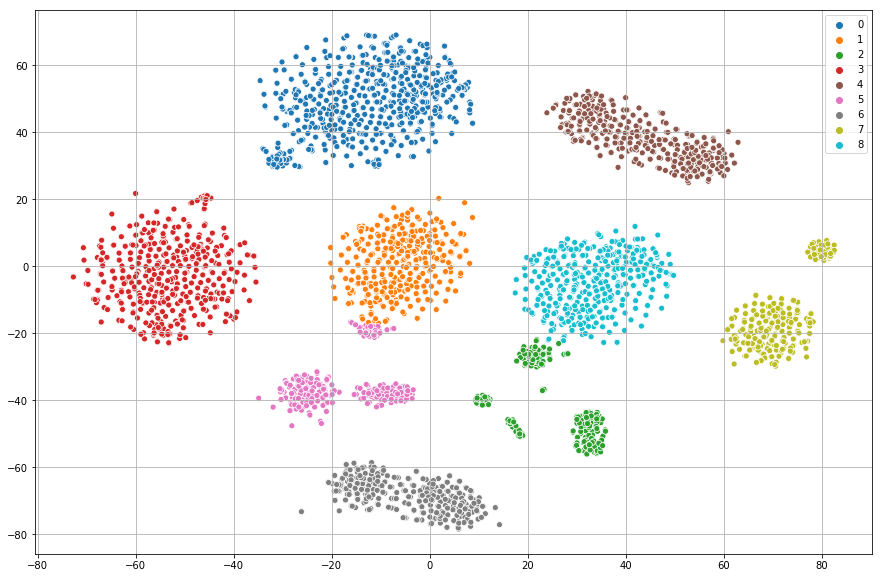

In [30]:
plt.figure(figsize=(15, 10))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=km.labels_, 
                palette="tab10", legend="full")
plt.grid()
plt.show()

### KNN non supervisionato

### Fit del modello NearestNeighbors sui dati

In [31]:
nn = NearestNeighbors(metric="cosine")
nn.fit(X)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=1.0)

### Estrazione grafo vicini

In [32]:
adj_matrix = nn.kneighbors_graph(X)
adj_matrix

<3720x3720 sparse matrix of type '<class 'numpy.float64'>'
	with 18600 stored elements in Compressed Sparse Row format>

### Creazione grafo networkx

In [33]:
G = nx.from_scipy_sparse_matrix(adj_matrix)

### Calcolo posizione nodi

In [34]:
pos = nx.spring_layout(G)

### Visualizzazione grafo

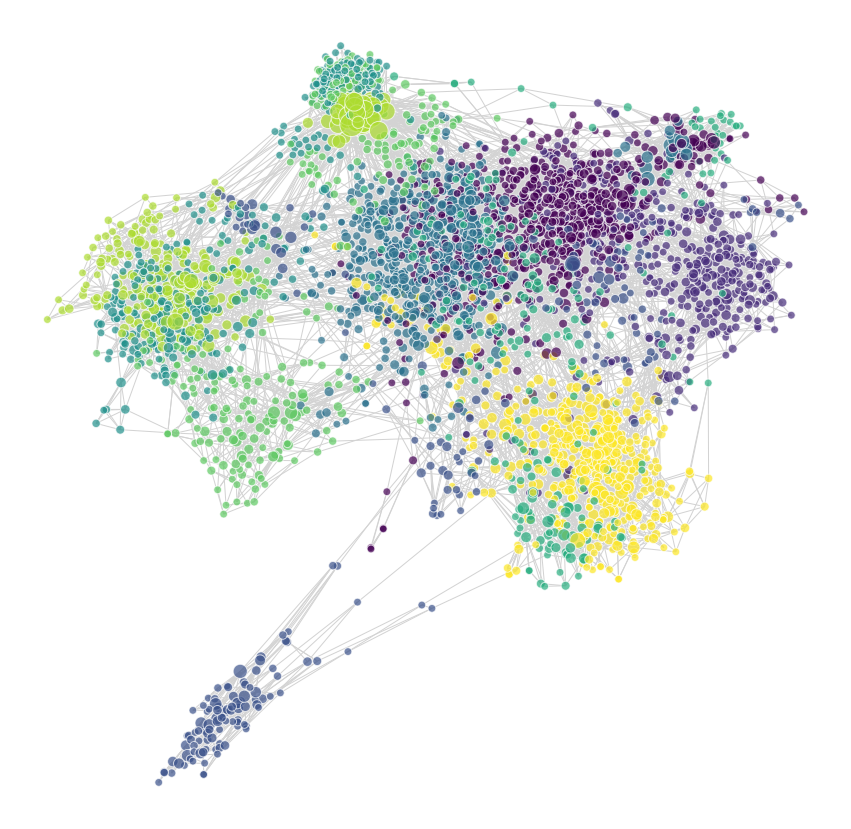

In [35]:
plt.figure(figsize=(15, 15))
# nodes
node_size = [G.degree(node) * 10 for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=km.labels_, alpha=0.7, edgecolors="white")
# edges
nx.draw_networkx_edges(G, pos, edge_color="lightgray")
plt.axis("off")
plt.show()

### Calcolo dei 5 elementi più vicini per ogni elemento 

In [36]:
distances, indices = nn.kneighbors(X, n_neighbors=11)

In [37]:
distances, indices

(array([[1.11022302e-16, 7.28443720e-02, 1.53473770e-01, ...,
         1.57316331e-01, 1.57654555e-01, 1.57728876e-01],
        [0.00000000e+00, 2.63761358e-01, 2.64674595e-01, ...,
         2.80321921e-01, 2.80801221e-01, 2.80860982e-01],
        [2.22044605e-16, 1.28054026e-01, 1.38405363e-01, ...,
         1.49705891e-01, 1.49778620e-01, 1.50023933e-01],
        ...,
        [0.00000000e+00, 1.32015958e-01, 1.34337224e-01, ...,
         1.36261091e-01, 1.36629680e-01, 1.37257552e-01],
        [0.00000000e+00, 5.48352802e-02, 5.65353522e-02, ...,
         6.34963269e-02, 6.41973905e-02, 6.55546656e-02],
        [0.00000000e+00, 9.47295926e-02, 9.54424825e-02, ...,
         9.82984220e-02, 9.83303443e-02, 9.84292682e-02]]),
 array([[   0,  322, 1339, ..., 1479,  796,  717],
        [   1,  385,    2, ...,  282,  190, 1470],
        [   2,  385,  115, ..., 1710,   52, 3075],
        ...,
        [3717, 3652, 1985, ..., 3534, 3699, 2686],
        [3718, 2746,  575, ...,  883, 3407, 3254

### Visualizzazione raccomandazione per The Legend of Zelda

In [38]:
df[df["name"].str.contains("Zelda")]

,name,platform,players,rating,text
1590,The Legend of Zelda: Breath of the Wild,0,0,1,nintendo nintendo action adventure forget ever...
1751,The Legend of Zelda: Breath of the Wild - The ...,0,1,1,nintendo nintendo action adventure new adventu...
1839,The Legend of Zelda: Breath of the Wild - The ...,0,1,1,nintendo nintendo action adventure the master ...


In [39]:
def get_recommendations(dataframe, game_index, model_neighbors):
    return [dataframe.iloc[game][0] for game in model_neighbors[game_index]][1:]

In [40]:
get_recommendations(dataframe=df, game_index=1590, model_neighbors=indices)

['Hyrule Warriors: Definitive Edition',
 'The Elder Scrolls V: Skyrim',
 'The Long Reach',
 'Furi',
 "Wasteland 2: Director's Cut",
 'Gone Home',
 "Don't Knock Twice",
 'Bayonetta + Bayonetta 2',
 'Bayonetta',
 'Garage']